## Настройка библиотек

### pandas

Для его настройки достаточно просто сделать импорт.

Также добавим numpy и matplotlib - пригодится для быстрых преобразований данных и визуализаций.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### pyspark

PySpark прежде всего требует установки самого Spark и платформы Java. Установим свободный JDK (Java development kit) версии 8. А Apache Spark скачаем версии 3.5.0 с Hadoop.

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

После этого в окружение среды нужно указать пути JAVA_HOME и SPARK_HOME на скачанные программы. Поскольку мы напрямую загрузили Spark, то он находится в директории content. Чтобы их добавить воспользуемся модулем os, который предоставляет интерфейс для взаимодействия с файловой системой.

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.0-bin-hadoop3"

Чтобы использовать PySpark как обычную Python-библиотеку, установим findspark, который сделает за нас остальную работу по инициализации.

In [4]:
!pip install findspark

Осталось инициализировать PySpark. Для этого вызывается метод findspark.init(), а дальше создаём точку входа кластера.

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Загрузка данных

Очень часто при анализе данных мы работаем с датасетами Kaggle — онлайн-площадки для соревнований по машинному обучению как в рамках конкурсов, так и для личных исследований. Обычно датасеты с Kaggle скачиваются напрямую на компьютер. Потом их загружают либо в Google Colab, либо в Google Drive. Причём если они загружаются с Drive, то придётся также их подгружать в Colab и вводить код доступа. Оба метода достаточно долгие, особенно если файлы большого размера. Поэтому загрузим файлы напрямую с Kaggle в Colab через Kaggle API.

Для этого, прежде всего необходимо создать аккаунт Kaggle (если у вас его еще нет). А затем в настройках аккаунта нужно создать API Token. Рисунок ниже показывает соответствующий раздел. После этого скачается файл kaggle.json, который содержит ваш личный код доступа.
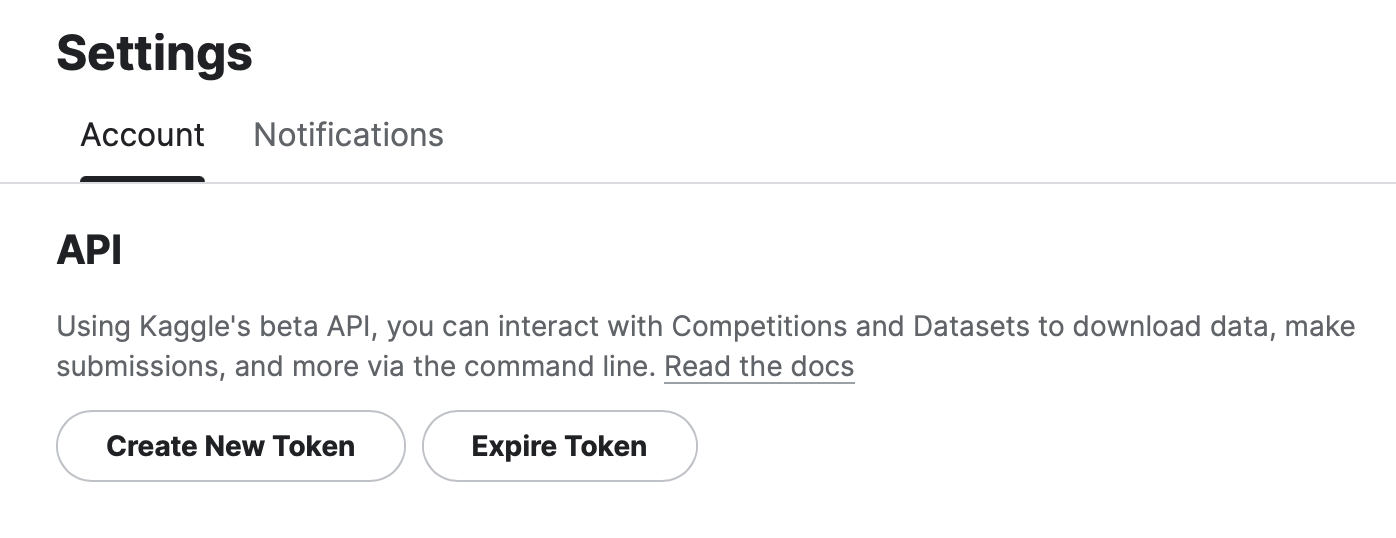

In [6]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"your_username","key":"your_key"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"igortulukin","key":"7a9d7ea832a773edc325dfa02cebefec"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


В этой и следующей практиках будем работать с [датасетом](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset), предназначенным для обучения алгоритма рекомендаций книг.

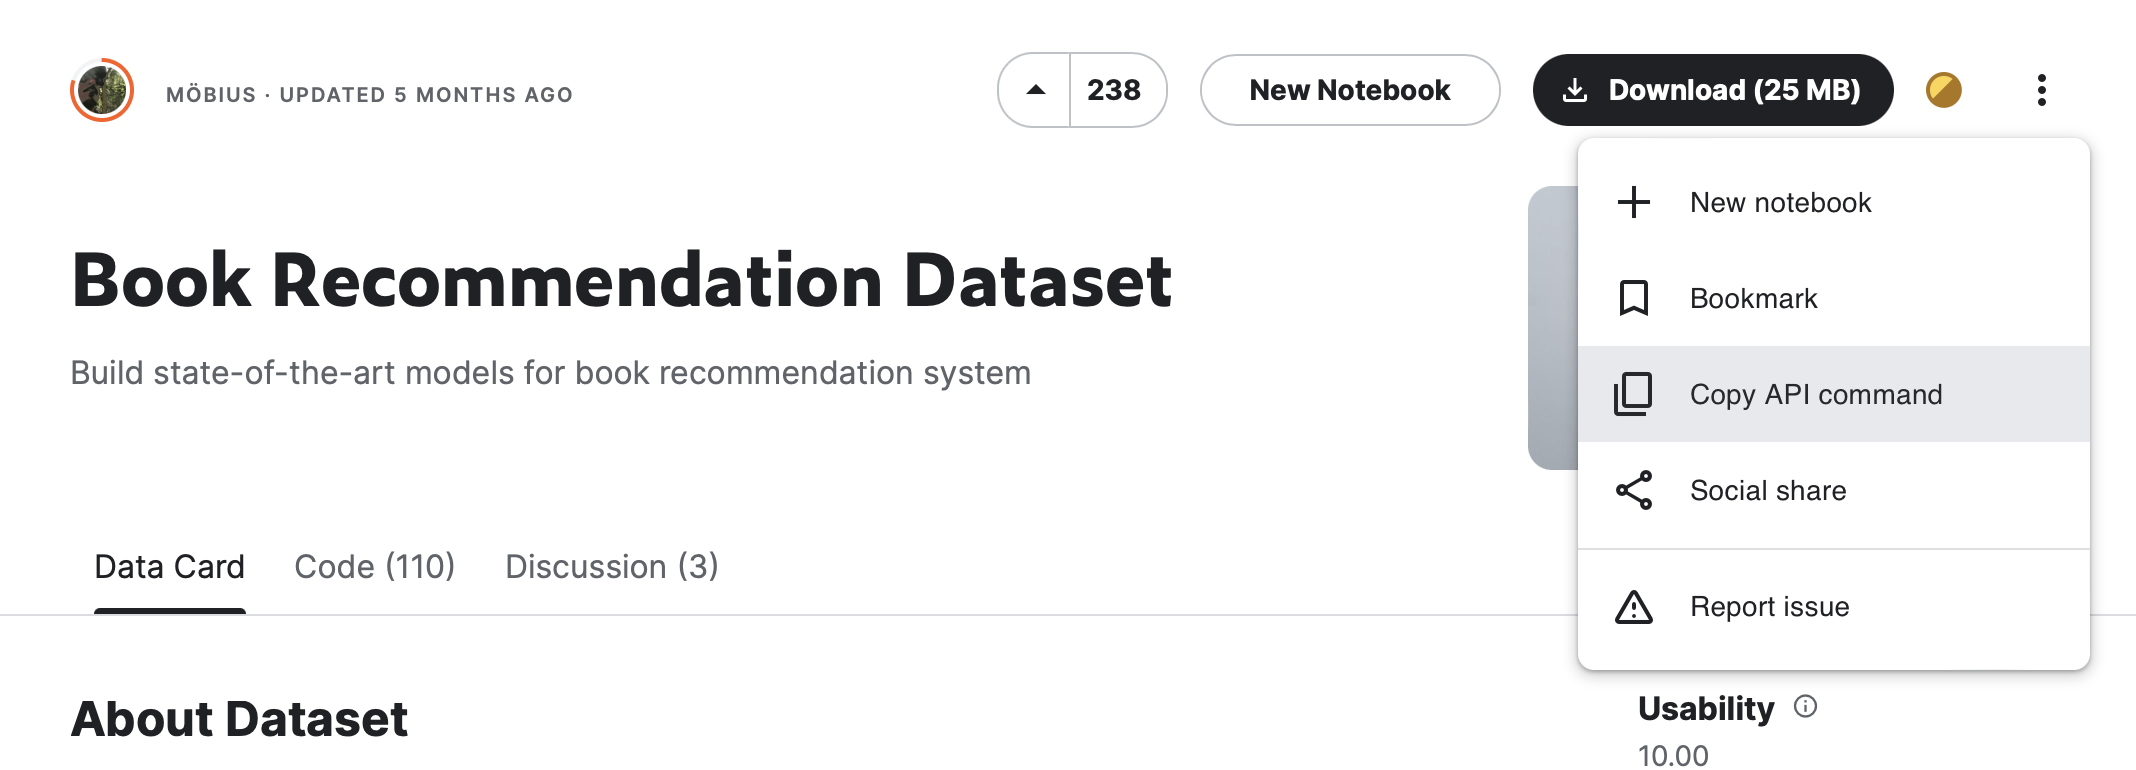

In [8]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

 38% 9.00M/23.8M [00:00<00:00, 50.9MB/s]
100% 23.8M/23.8M [00:00<00:00, 99.5MB/s]


In [9]:
!unzip -q book-recommendation-dataset.zip

## Упражнения с данными в pandas

### Подготовка

Загрузим данные и посмотрим на них: выведите по 3 первые строки каждого датафрейма с помощью метода  [head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html).

In [ ]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

display(books.head(3))
display(ratings.head(3))
display(users.head(3))

<ipython-input-28-3b325d4d72fd>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


Посмотрим на размеры датафреймов.

In [ ]:
books.shape, ratings.shape, users.shape

((271360, 8), (1149780, 3), (278858, 3))

Воспользуйтесь [функцией](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge) или [методом](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) merge, чтобы объединить три датафрейма в один.

In [ ]:
merged_data = pd.merge(books, ratings)
data = pd.merge(merged_data, users)
print(data['Age'].unique())
display(data.head(5))

NameError: ignored

В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью метода [str.split()](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html) с параметром expand=True. Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) с параметром inplace=True, чтобы не создавать новую таблицу. Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [ ]:
data[['City', 'Region', 'Country', '', '','', '']] = data['Location'].str.split(', ', expand=True)
data.drop('', axis=1, inplace=True)
display(data.head(5))

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,City,Region,Country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN,timmins,ontario,canada
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",NaN,timmins,ontario,canada
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",NaN,timmins,ontario,canada


Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

<function matplotlib.pyplot.show(close=None, block=None)>

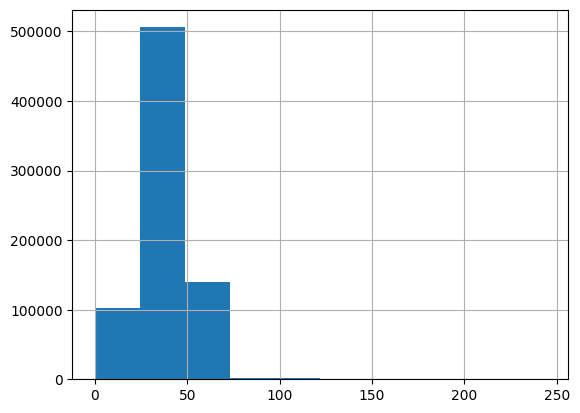

In [ ]:
data.Age.describe()
hist = data["Age"].hist()
plt.show

Было бы неплохо не смотреть на то, что читают младенцы и мумии: посмотрим на возраст больше 0 и меньше 100. Для того, чтобы отсеять лишние строки, можно воспользоваться методом [query()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html).

В конце строки, отвечающей за вывод визуализации для вывода изображения без лишних указателей, можно поставить `;` или в следующей строке написать plt.show().

<function matplotlib.pyplot.show(close=None, block=None)>

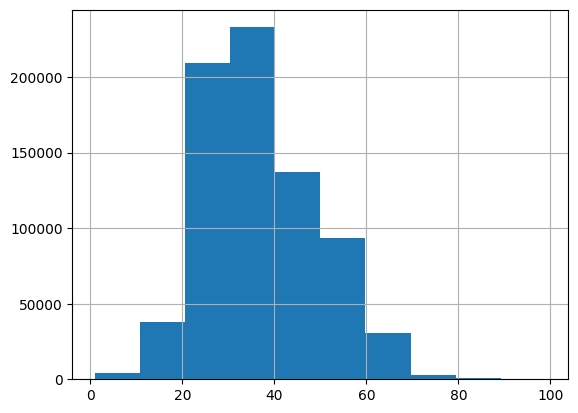

In [ ]:
data = data.query("Age > 0 and Age < 100")
hist = data["Age"].hist()
plt.show


Какой можно сделать вывод о возрасте пользователей?

Для пользователей с возрастом больше 100 лет поставим значение возраста np.nan. Можно сделать это с помощью метода [apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html), например.

In [ ]:
def replace_age(x):
    if x > 100:
        return np.nan
    else:
        return x
data['Age'] = data['Age'].apply(replace_age)

2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.

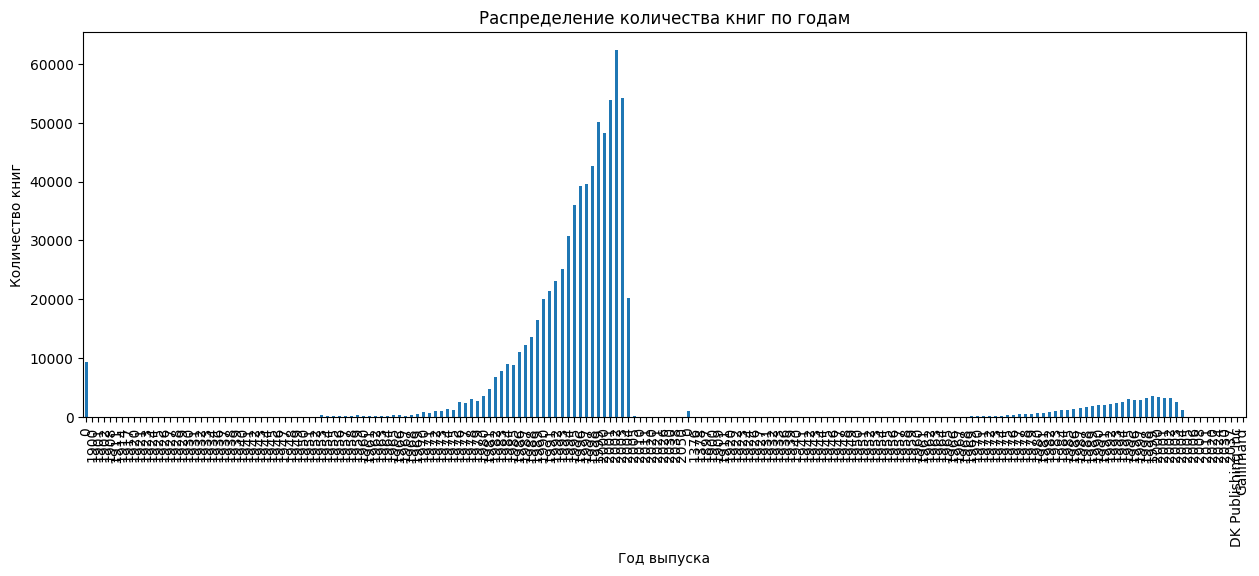

In [ ]:
books_by_year = data.groupby(['Year-Of-Publication'])['Book-Title'].count()
books_by_year.plot(kind='bar', figsize=(15, 5))
plt.title('Распределение количества книг по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество книг')
plt.show()

Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрите, нет ли чего несанкционированного в столбце с датой, например, выведя уникальные значения с помощью метода [unqiue()](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).

In [ ]:
data['Year-Of-Publication'].unique()

array([2002, 2001, 2003, 1998, 1993, 1999, 1992, 2000, 1989, 1996, 1988,
       1976, 1985, 1991, 1980, 2004, 1995, 1997, 1994, 0, 1986, 1990,
       1987, 1984, 1983, 1938, 1974, 1981, 1951, '2002', '1999', '1996',
       '2003', '2004', '1997', '1984', '1988', '1990', '2001', '1991',
       '1993', '1994', '1998', '2000', '0', '1995', '1985', '1977',
       '1989', '1975', '1983', 1977, 1925, 1971, 1970, 1973, 1967, 1982,
       1969, 1979, 1963, 1953, 1978, 1956, '1964', '1981', '1976', '1992',
       '1978', '1987', '1986', 1965, 1972, 1901, 1964, 2030, 1927, 1975,
       1923, 1954, 1958, 1955, 1966, 1926, 1968, 1961, 1940, 1959, '1979',
       '1941', '1982', '1959', '1980', '1972', '1970', '1942', '1974',
       '1966', '1963', '1973', '1962', '1922', '1969', '1957', '1897',
       '1971', '1958', '1968', '1960', '1949', '1967', '1956', '1939',
       '1955', '1961', '1952', '1933', '1954', '1965', '1944', 1962, 1952,
       1957, 1948, 2011, 1960, '1951', 1902, 1920, '1920', 19

Часть чисел имеет вид строки - преобразовать не проблема. Но есть и две настоящих строки, на вид - названия издательств. Давайте посмотрим на строки с такими значениями.

In [ ]:
str_data = data[(data['Year-Of-Publication'] == 'DK Publishing Inc') | (data['Year-Of-Publication'] == 'Gallimard')]
display(str_data)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,City,Region,Country
287500,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN,137190,0,"rennes, bretagne, france",31.0,rennes,bretagne,france
352361,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,227771,7,"savion, n/a, israel",19.0,savion,n/a,israel


В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.
>В качестве дополнительного упражнения верните порядок в эти строки с помощью pandas.

In [ ]:
data = data[(data['Year-Of-Publication'] != 'DK Publishing Inc') & (data['Year-Of-Publication'] != 'Gallimard')]
data['Year-Of-Publication'].unique()

array([2002, 2001, 2003, 1998, 1993, 1999, 1992, 2000, 1989, 1996, 1988,
       1976, 1985, 1991, 1980, 2004, 1995, 1997, 1994, 0, 1986, 1990,
       1987, 1984, 1983, 1938, 1974, 1981, 1951, '2002', '1999', '1996',
       '2003', '2004', '1997', '1984', '1988', '1990', '2001', '1991',
       '1993', '1994', '1998', '2000', '0', '1995', '1985', '1977',
       '1989', '1975', '1983', 1977, 1925, 1971, 1970, 1973, 1967, 1982,
       1969, 1979, 1963, 1953, 1978, 1956, '1964', '1981', '1976', '1992',
       '1978', '1987', '1986', 1965, 1972, 1901, 1964, 2030, 1927, 1975,
       1923, 1954, 1958, 1955, 1966, 1926, 1968, 1961, 1940, 1959, '1979',
       '1941', '1982', '1959', '1980', '1972', '1970', '1942', '1974',
       '1966', '1963', '1973', '1962', '1922', '1969', '1957', '1897',
       '1971', '1958', '1968', '1960', '1949', '1967', '1956', '1939',
       '1955', '1961', '1952', '1933', '1954', '1965', '1944', 1962, 1952,
       1957, 1948, 2011, 1960, '1951', 1902, 1920, '1920', 19

Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [astype()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html).

In [ ]:
data['Year-Of-Publication'] = data['Year-Of-Publication'].fillna(0).astype('int')
data['Year-Of-Publication'].unique()

array([2002, 2001, 2003, 1998, 1993, 1999, 1992, 2000, 1989, 1996, 1988,
       1976, 1985, 1991, 1980, 2004, 1995, 1997, 1994,    0, 1986, 1990,
       1987, 1984, 1983, 1938, 1974, 1981, 1951, 1977, 1975, 1925, 1971,
       1970, 1973, 1967, 1982, 1969, 1979, 1963, 1953, 1978, 1956, 1964,
       1965, 1972, 1901, 2030, 1927, 1923, 1954, 1958, 1955, 1966, 1926,
       1968, 1961, 1940, 1959, 1941, 1942, 1962, 1922, 1957, 1897, 1960,
       1949, 1939, 1952, 1933, 1944, 1948, 2011, 1902, 1920, 1950, 1930,
       1911, 1943, 1947, 1945, 2005, 1946, 1937, 1932, 1924, 1921, 2038,
       2021, 1900, 2026, 2050, 1929, 2020, 1936, 2006, 1931, 1934, 1378,
       2010, 2008, 1917, 1928, 1914, 2037, 2024, 1909, 1376, 1908])

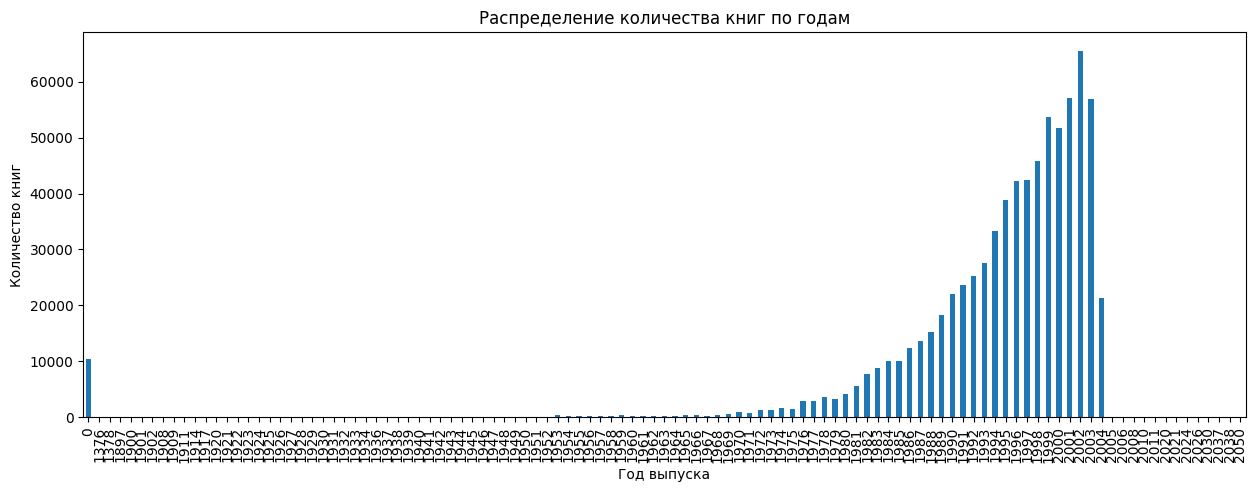

In [ ]:
books_by_year = data.groupby(['Year-Of-Publication'])['Book-Title'].count()
books_by_year.plot(kind='bar', figsize=(15, 5))
plt.title('Распределение количества книг по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество книг')
plt.show()

3. Покажем на [столбчатой диаграмме](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html) топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html). Не забудьте отсортировать столбцы ([sort_values()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)).

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
       'Location', 'Age', 'City', 'Region', 'Country'],
      dtype='object')


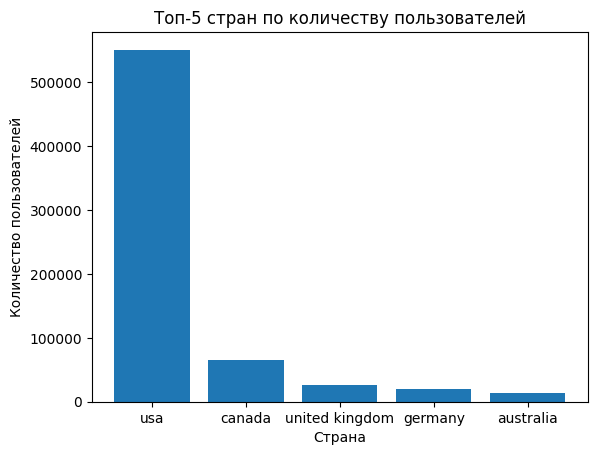

In [ ]:
print(data.keys())
users_by_country = data.groupby(data['Country'])['User-ID'].count()

top_countries = users_by_country.sort_values(ascending=False)[:5]

plt.bar(top_countries.index, top_countries.values)

plt.xlabel('Страна')
plt.ylabel('Количество пользователей')
plt.title('Топ-5 стран по количеству пользователей')
plt.show()

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [ ]:
data = data[(data['Country'] == 'russia') | (data['Country'] == 'usa')]
mean_ratings = data.groupby(['ISBN', 'Country'])['Book-Rating'].mean()
print(mean_ratings)

ISBN        Country
0001047868  usa        0.0
0001056107  usa        8.0
000123207X  usa        0.0
0001232088  usa        0.0
0001714600  usa        8.0
                      ... 
B0001GMSV2  usa        8.0
B0001GMSVW  usa        0.0
B0001PIOX4  usa        0.0
B000234N3A  usa        9.0
B000234NC6  usa        0.0
Name: Book-Rating, Length: 170724, dtype: float64


2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [ ]:
books_by_year = data.groupby('Year-Of-Publication')['Book-Title'].count()
print('Наибольшее:', books_by_year.idxmax(), books_by_year.max())
print('Наименьшее:',books_by_year.idxmin(), books_by_year.min())

Наибольшее: 2002 48214
Наименьшее: 1897 1


## Упражнения с данными в pyspark

Повторим все те же действия, но с помощью PySpark.

### Подготовка

Загрузим данные и посмотрим на них. Метод show() зпускает выполнение операций, прописанных для датафрейма.

In [10]:
books = spark.read.option("header", True).csv("Books.csv")
ratings = spark.read.option("header", True).csv("Ratings.csv")
users = spark.read.option("header", True).csv("Users.csv")
books.show()
ratings.show()
users.show()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

Посмотрим на размеры датафреймов.

In [11]:
(books.count(), len(books.columns)), (ratings.count(), len(ratings.columns)), (users.count(), len(users.columns))

((271360, 8), (1149780, 3), (278859, 3))

Воспользуйтесь [функцией](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.join.html) join, чтобы объединить три датафрейма в один.

In [12]:
merged = books.join(ratings, on='ISBN').join(users, on='User-ID')
merged.show()

+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|User-ID|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating|            Location| Age|
+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|   1000|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|          0|teramo, abruzzo, ...|34.0|
| 100004|0345339703|The Fellowship of...|      J.R.R. TOLKIEN|               1986|             Del Rey|http://images.ama...|http://images.ama...|http://images.ama...|         10|sa

In [13]:
(merged.count(), len(merged.columns))

(1031136, 12)

В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью функции [split()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.split.html) и функции [withColumn()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.withColumn.html). Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.drop.html). Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [14]:
from pyspark.sql.functions import split


merged = merged.withColumn('City', split(merged['Location'], ',')[0])
merged = merged.withColumn('Region', split(merged['Location'], ',')[1])
merged = merged.withColumn('Country', split(merged['Location'], ',')[2])

merged = merged.drop('Location')
merged.show()

+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+----+----------+-----------------+-------+
|User-ID|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating| Age|      City|           Region|Country|
+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+----+----------+-----------------+-------+
|   1000|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|          0|34.0|    teramo|          abruzzo|  italy|
| 100004|0345339703|The Fellowship of...|      J.R.R. TOLKIEN|               1986|             Del Rey|http://images

Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

In [15]:
from pyspark.sql.types import FloatType

merged = merged.filter("Age != ''")

merged_ages = merged.select(merged['Age'].cast(FloatType()))
merged_ages.distinct().show()

+-----+
|  Age|
+-----+
| 18.0|
| 64.0|
|239.0|
|219.0|
| 82.0|
| 47.0|
|  9.0|
| 58.0|
|101.0|
| 39.0|
|  5.0|
|132.0|
| 30.0|
| 17.0|
| 90.0|
| 26.0|
| 41.0|
| 86.0|
| 29.0|
|201.0|
+-----+
only showing top 20 rows



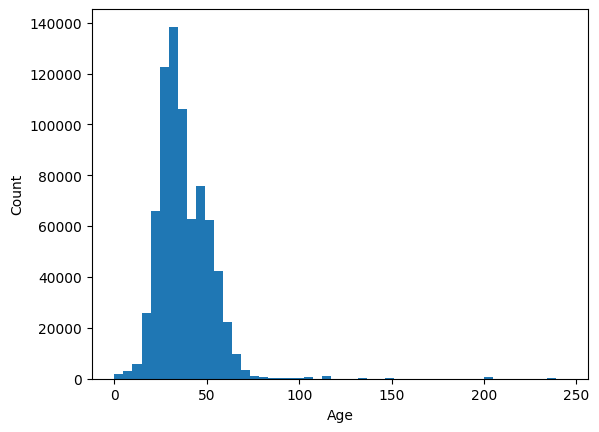

In [16]:
ages = merged_ages.toPandas()

plt.hist(ages['Age'], bins=50)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Для того, чтобы отсеять лишние строки, можно воспользоваться методом [filter()/where()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.filter.html).

Для сортировки можно воспользоваться методом [sort()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sort.html).

In [17]:
merged = merged.filter("age > 0").filter("age < 100")

Какой можно сделать вывод о возрасте пользователей?

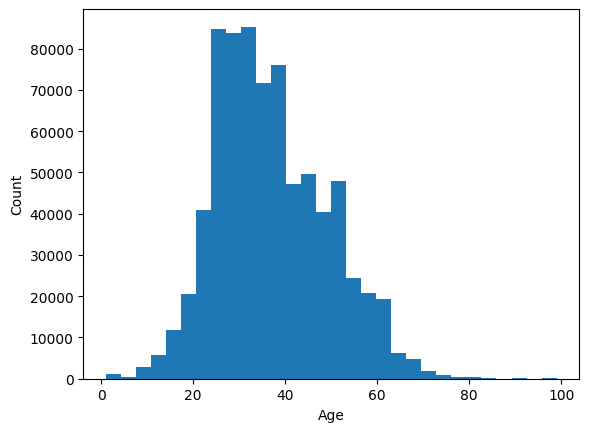

In [18]:
from pyspark.sql.types import FloatType

merged_ages = merged.select(merged['Age'].cast(FloatType()))
ages = merged_ages.toPandas()
plt.hist(ages['Age'], bins=30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.

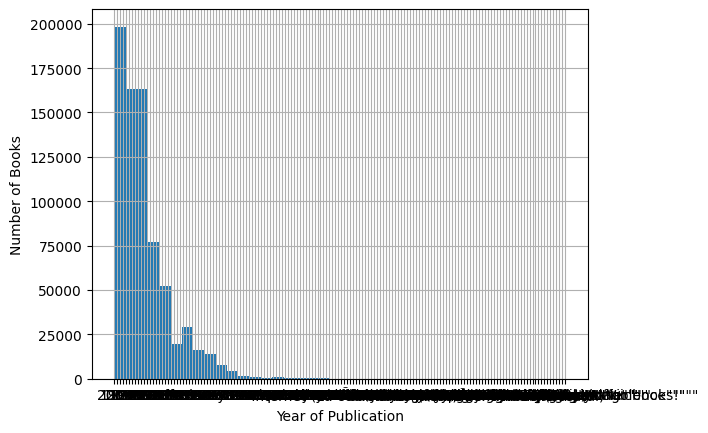

In [19]:
book_dates = merged.toPandas()
book_dates['Year-Of-Publication'].hist(bins=40)
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books')
plt.show()

Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрим на уникальные значения с помощью метода [distinct()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.distinct.html).

In [22]:
merged.select('Year-Of-Publication').distinct().show()

+--------------------+
| Year-Of-Publication|
+--------------------+
|                1953|
|                1957|
|                1897|
|                1987|
|                1956|
|                1936|
|                2020|
|                1958|
|                1943|
|                1972|
|                1931|
| and tasty! : com...|
| and Musicians at...|
| and Box-Office M...|
|                1988|
|                1911|
|                1926|
|                1938|
|\"" \""Drachenste...|
|                1932|
+--------------------+
only showing top 20 rows



В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.

In [23]:
from pyspark.sql.functions import regexp_extract

merged = merged.filter(regexp_extract(merged["Year-Of-Publication"], r'\d+', 0) == merged["Year-Of-Publication"])

Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [cast()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.cast.html).

In [25]:
from pyspark.sql.types import FloatType

merged_dates = merged.select(merged['Year-Of-Publication'].cast(FloatType()))

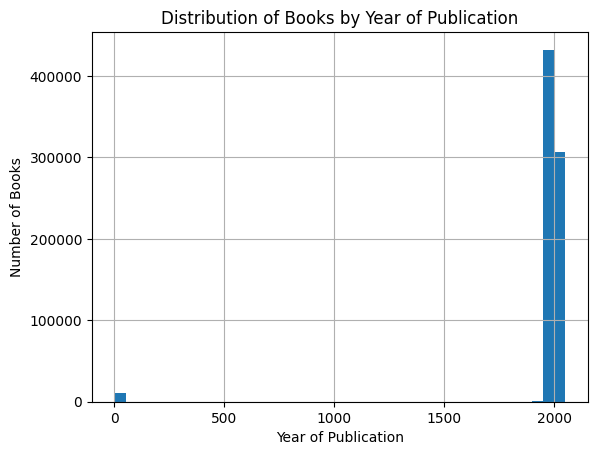

In [26]:
book_dates = merged_dates.toPandas()
book_dates['Year-Of-Publication'].hist(bins=40)
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books')
plt.title('Distribution of Books by Year of Publication')
plt.show()

3. Покажем на столбчатой диаграмме топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupBy()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html). Не забудьте отсортировать столбцы.

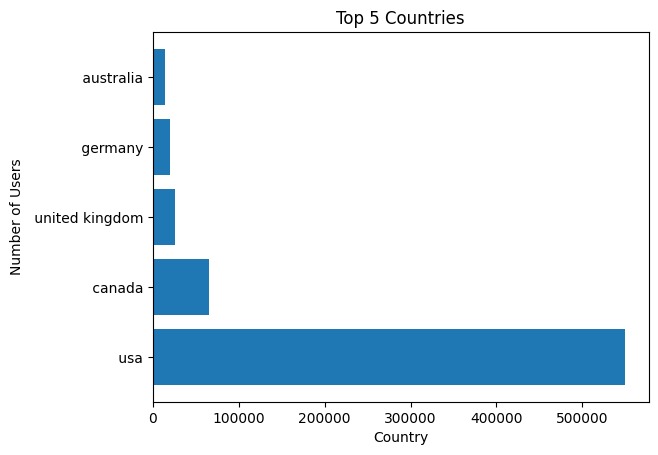

In [27]:
country_counts = merged.groupBy(['Country']).count().sort("count", ascending=False)
top_countries = country_counts.toPandas()[:5]
plt.barh(top_countries['Country'], top_countries['count'])
plt.title('Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.show()

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [ ]:
filtered_df =  merged.filter(merged["Book-Rating"] > 0)
ratings_usa = filtered_df.filter((filtered_df["Country"].like("%usa%")))
ratings_russia = filtered_df.filter((filtered_df["Country"].like("%russia%")))
common_books = ratings_usa.join(ratings_russia, "ISBN", "inner")
ratings_usa = ratings_usa.join(common_books.select("ISBN"), "ISBN", "inner")
ratings_russia = ratings_russia.join(common_books.select("ISBN"), "ISBN", "inner")

In [30]:
ratings_usa.show()
ratings_russia.show()

+----------+-------+--------------------+----------------+-------------------+-----------------+--------------------+--------------------+--------------------+-----------+----+--------+-----------+-------+
|      ISBN|User-ID|          Book-Title|     Book-Author|Year-Of-Publication|        Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating| Age|    City|     Region|Country|
+----------+-------+--------------------+----------------+-------------------+-----------------+--------------------+--------------------+--------------------+-----------+----+--------+-----------+-------+
|0679760806| 221040|The Master and Ma...|Mikhail Bulgakov|               1996|Vintage Books USA|http://images.ama...|http://images.ama...|http://images.ama...|         10|29.0|montrose| california|    usa|
|0679760806| 221040|The Master and Ma...|Mikhail Bulgakov|               1996|Vintage Books USA|http://images.ama...|http://images.ama...|http://images.ama...|         10|29.0|

In [31]:
from pyspark.sql.functions import col, avg
avg_rating_usa = ratings_usa.agg(avg(col("Book-Rating")).alias("AvgUSA"))
avg_rating_russia = ratings_russia.agg(avg(col("Book-Rating")).alias("AvgRussia"))
avg_usa = avg_rating_usa.first()["AvgUSA"]
avg_russia = avg_rating_russia.first()["AvgRussia"]
print("USA:", avg_usa)
print("Russia:", avg_russia)

USA: 7.700669696244917
Russia: 10.0


2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [32]:
count_books = merged_dates.groupBy(['Year-Of-Publication']).count().sort("count")
count_books.show(1)
count_books = merged_dates.groupBy(['Year-Of-Publication']).count().sort("count", ascending=False)
count_books.show(1)

+-------------------+-----+
|Year-Of-Publication|count|
+-------------------+-----+
|             2024.0|    1|
+-------------------+-----+
only showing top 1 row

+-------------------+-----+
|Year-Of-Publication|count|
+-------------------+-----+
|             2002.0|65571|
+-------------------+-----+
only showing top 1 row

